# Generative Adversarial Network

## 导入库

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

## 超参

In [2]:
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1)
N_Z = 64
EPOCH = 100

## 导入数据

In [3]:
(train_images, _), (test_images, _) = keras.datasets.fashion_mnist.load_data()

## 数据处理

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

## 数据导入tfdataset 

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

## 生成器

In [6]:
generator = [
    keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    keras.layers.Reshape(target_shape=(7, 7, 64)),
    keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"),
    keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"),
    keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"),
]

## 鉴别器

In [7]:
discriminator = [
    keras.layers.InputLayer(input_shape=DIMS),
    keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation="relu"),
    keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation="relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(units=1, activation=None),
]

## 损失

In [8]:
def gan_loss(logits, is_real=True):
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    return tf.compat.v1.losses.sigmoid_cross_entropy(multi_class_labels=labels, logits=logits)

## 定义模型

In [9]:
class GAN(tf.keras.Model):
    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])
        x_gen = self.generate(z_samp)
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)
        disc_real_loss = gan_loss(logits=logits_x, is_real=True)
        disc_fake_loss = gan_loss(logits=logits_x_gen, is_real=False)
        disc_loss = disc_fake_loss + disc_real_loss
        gen_loss = gan_loss(logits=logits_x_gen, is_real=True)
        return disc_loss, gen_loss

    def compute_gradients(self, x):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)
        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):
        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.gen.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.disc.trainable_variables))
    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)

## 优化器

In [10]:
gen_optimizer = keras.optimizers.Adam(0.001, beta_1=0.5)
disc_optimizer = keras.optimizers.RMSprop(0.005)

## 加载模型

In [11]:
model = GAN(gen = generator, disc = discriminator, gen_optimizer = gen_optimizer, disc_optimizer = disc_optimizer, n_Z = N_Z)

## 存储损失 

In [12]:
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

## 绘制

In [13]:
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1)
        axs[axi].axis('off')
    plt.show()

## 训练

Epoch: 99 | disc_loss: 0.8890314102172852 | gen_loss: 1.2309857606887817


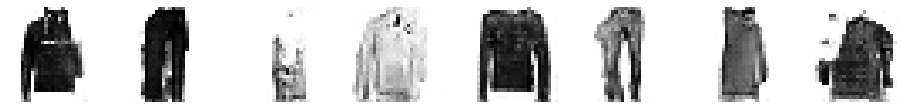

In [14]:
for epoch in range(EPOCH):
    for batch, train_x in enumerate(train_dataset):
        model.train(train_x)
    loss = []
    for batch, test_x in enumerate(test_dataset):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    display.clear_output()
    print("Epoch: {} | disc_loss: {} | gen_loss: {}".format(epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]))
    plot_reconstruction(model)

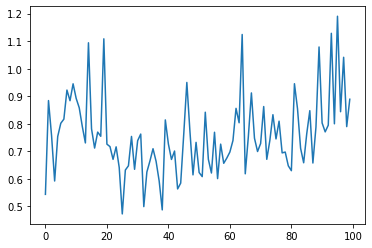

In [15]:
plt.plot(losses.disc_loss.values)

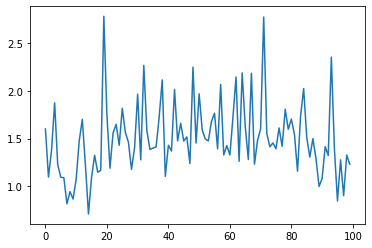

In [16]:
plt.plot(losses.gen_loss.values)

In [18]:
model.save_weights('./save/save_weights/model_weights.h5')